In [1]:
import random
import glob
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import models

In [2]:
PATH = "./data/chest-xray-pneumonia/chest_xray/chest_xray/"

In [3]:
size = 299
batch_size = 64
seed = 42

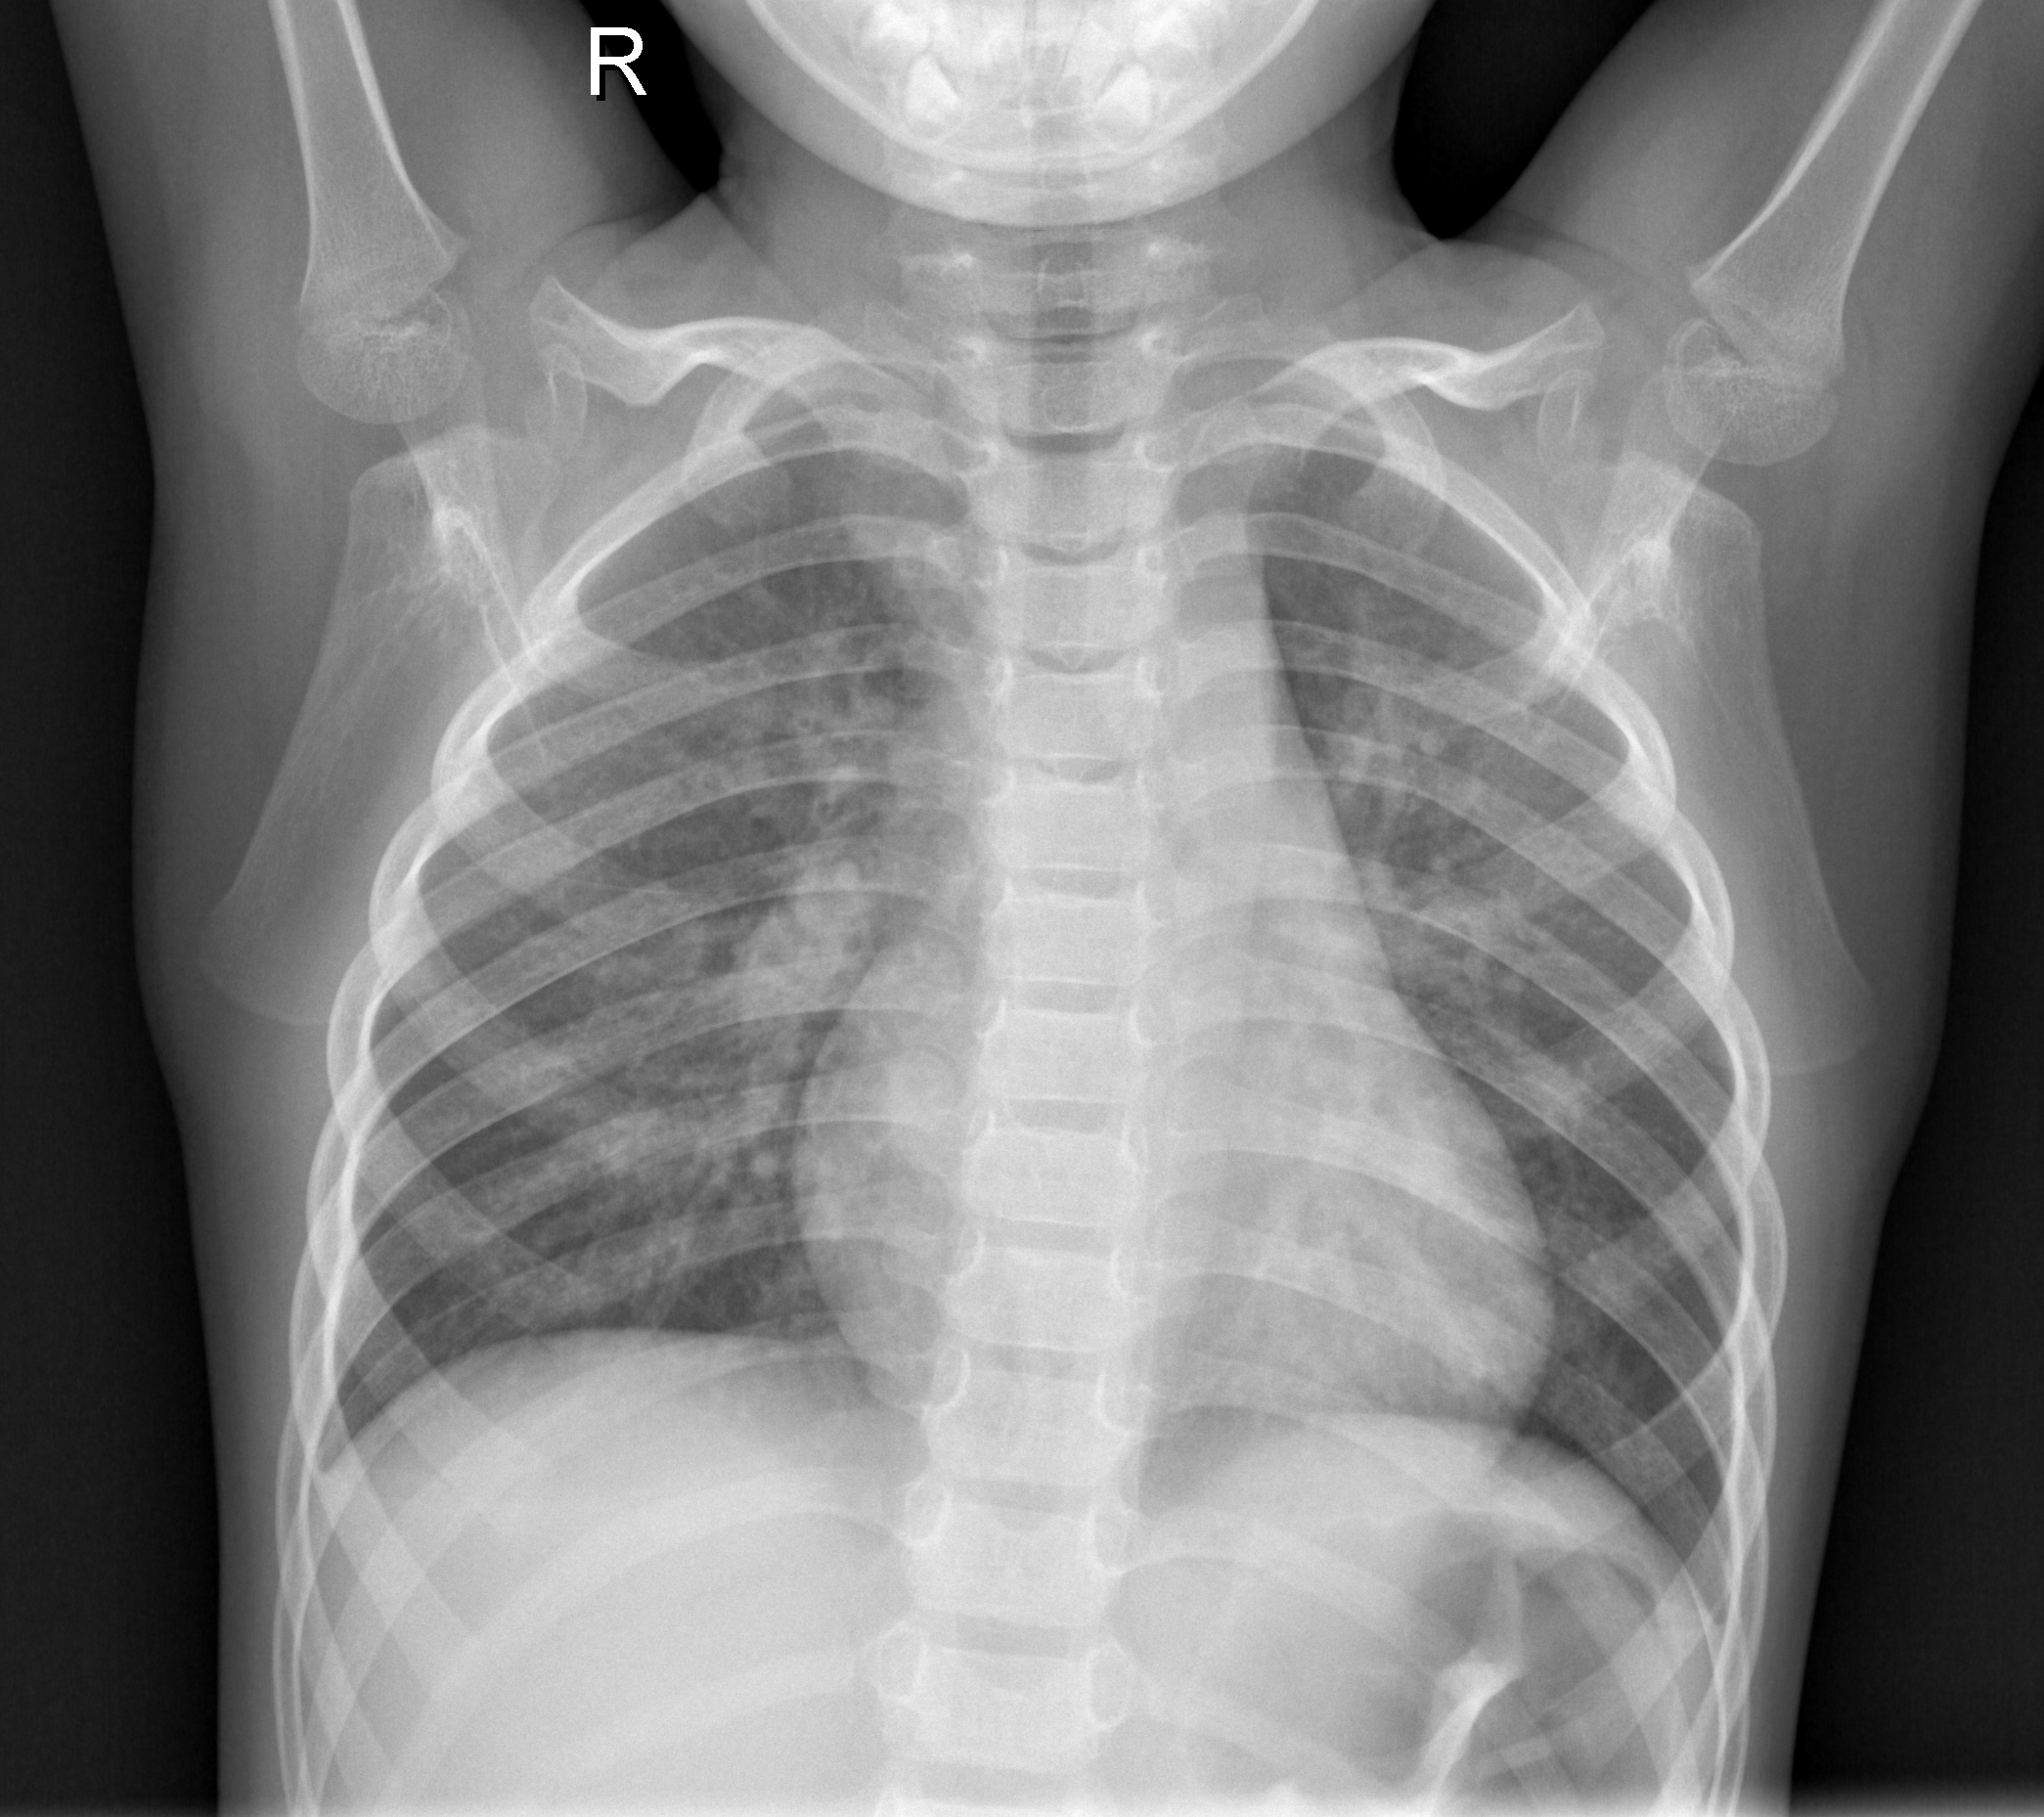

In [4]:
example_img = Image.open(PATH + "train/NORMAL/IM-0115-0001.jpeg")
example_img

In [5]:
class XRayDataset(Dataset):
    def __init__(self, path, size, p_flip=0.5, p_light=0.75, p_zoom=0.75):
        normal_imgs_path = glob.glob(PATH + f"{path}/NORMAL/*.jpeg")
        pneumonia_imgs_path = glob.glob(PATH + f"{path}/PNEUMONIA/*.jpeg")
        self.imgs_path = normal_imgs_path + pneumonia_imgs_path

        labels = [0] * len(normal_imgs_path) + [1] * len(pneumonia_imgs_path)
        self.labels = torch.tensor(labels).float()

        self.path = path
        self.size = size
        self.p_flip = p_flip
        self.p_light = p_light
        self.p_zoom = p_zoom

        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.open(self.imgs_path[idx])

        if self.path == "train":
            temp_size = np.random.randint(700, 900)
        else:
            temp_size = 800

        img = TF.center_crop(img, (temp_size, temp_size))
        img = TF.resize(img, (self.size, self.size))

        if self.path == "train" and random.random() < self.p_flip:
            img = TF.hflip(img)

        if self.path == "train" and random.random() < self.p_zoom:
            zoom = np.random.uniform(1, 1.1)
            img = TF.affine(img, 0, (0, 0), zoom, 0)

        if self.path == "train" and random.random() < self.p_light:
            factor = np.random.uniform(0.8, 1.2)
            img = TF.adjust_brightness(img, factor)

        if self.path == "train" and random.random() < self.p_light:
            factor = np.random.uniform(0.8, 1.2)
            img = TF.adjust_contrast(img, factor)

        img = TF.to_tensor(img)

        # Some images are grey-scaled, copying the channels for transfer-learning
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)

        img = TF.normalize(img, self.mean, self.std)
        return img, self.labels[idx]

In [6]:
train_dataset = XRayDataset("train", size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_dataset = XRayDataset("test", size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
class Model(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-1]
        self.backbone = nn.Sequential(*pretrained_model)
        self.dropout = nn.Dropout(p=p)
        self.linear = nn.Linear(512, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(len(x), -1)
        x = self.dropout(x)
        x = self.linear(x)
        x = x.view(len(x))
        return x

In [8]:
device = "cuda"
threshold = 0.5
n_epochs = 2
lr = 1e-2
wd = 1e-3

In [9]:
torch.manual_seed(seed)
model = Model().to(device)

optimizer = optim.Adam([
    {"params": model.backbone.parameters(), "lr": lr / 100},
    {"params": model.linear.parameters(), "lr": lr}],
    weight_decay=wd
)

In [10]:
loss_fct = nn.BCEWithLogitsLoss()

In [11]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for epoch in range(0, n_epochs):
    train_loss, test_loss, train_acc, test_acc = 0.0, 0.0, 0.0, 0.0

    model.train()
    for _, (x, y) in enumerate(train_loader):
            model.zero_grad()

            x, y = x.to(device), y.to(device)
            output = model(x)
            batch_loss = loss_fct(output, y)

            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss.detach().cpu().numpy() / x.shape[0]

            y_pred = (torch.sigmoid(output) > threshold).float().detach()
            train_acc += (y == y_pred).float().mean().cpu().numpy()

    model.eval()
    with torch.no_grad():
        for _, (x, y) in enumerate(test_loader):
                    x, y = x.to(device), y.to(device)
                    output = model(x)

                    batch_loss = loss_fct(output, y)
                    test_loss += batch_loss.cpu().numpy() / x.shape[0]

                    y_pred = (torch.sigmoid(output) > threshold).float()
                    test_acc += (y == y_pred).float().mean().cpu().numpy()

    train_loss = np.round(train_loss / len(train_loader), 6)
    test_loss = np.round(test_loss / len(test_loader), 6)

    train_acc = np.round(train_acc / len(train_loader), 6)
    test_acc = np.round(test_acc / len(test_loader), 6)

    print(f"------ Epoch: {epoch} ------")
    print(f"Train loss: {train_loss}")
    print(f"Test loss: {test_loss}")
    print(f"Train acc: {train_acc}")
    print(f"Test acc: {test_acc}")

------ Epoch: 0 ------
Train loss: 0.003411
Test loss: 0.003621
Train acc: 0.917492
Test acc: 0.916667
------ Epoch: 1 ------
Train loss: 0.002217
Test loss: 0.003172
Train acc: 0.949314
Test acc: 0.932292
